In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=1000):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileinprefix = "SnapshotAr41*.csv"
df_ar41 = load_dataframe_from_files(dirin, fileinprefix)
df_ar41 = df_ar41[df_ar41.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 1 files wt prefix:
SnapshotAr41*.csv

[Info] Loaded data in 0.041 seconds


In [4]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileinprefix = "Snapshot1Ar39*.csv"
df_ar39 = load_dataframe_from_files(dirin, fileinprefix)
df_ar39 = df_ar39[df_ar39.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*.csv
...................................................................................................
[Info] Loaded data in 71.012 seconds


# select data

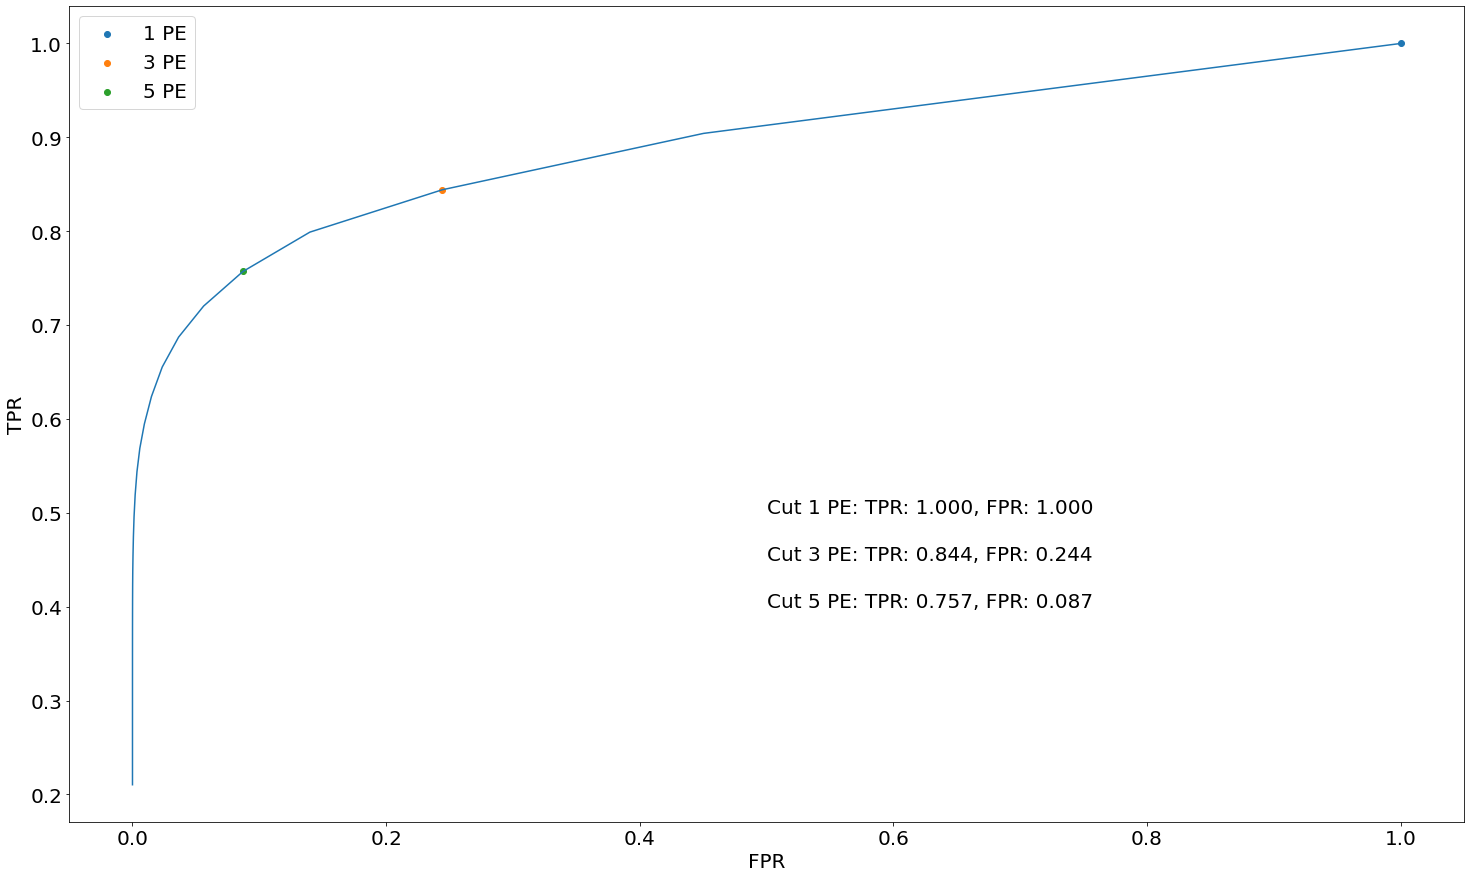

In [12]:
roc_tprs, roc_fprs, roc_thresholds = [], [], []
for pe in range(0, 40):
    tpr = len(df_ar41[(df_ar41.pedetected>=pe)]) / len(df_ar41)
    fpr = len(df_ar39[(df_ar39.pedetected>=pe)]) / len(df_ar39)
    roc_tprs.append(tpr)
    roc_fprs.append(fpr)
    roc_thresholds.append(pe)
plt.plot(roc_fprs, roc_tprs)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.scatter(roc_fprs[roc_thresholds.index(1)], roc_tprs[roc_thresholds.index(1)], label="1 PE")
plt.scatter(roc_fprs[roc_thresholds.index(3)], roc_tprs[roc_thresholds.index(3)], label="3 PE")
plt.scatter(roc_fprs[roc_thresholds.index(5)], roc_tprs[roc_thresholds.index(5)], label="5 PE")
plt.text(.5, .5, "Cut {} PE: TPR: {:.3f}, FPR: {:.3f}".format(1, roc_tprs[roc_thresholds.index(1)], roc_fprs[roc_thresholds.index(1)]))
plt.text(.5, .45, "Cut {} PE: TPR: {:.3f}, FPR: {:.3f}".format(3, roc_tprs[roc_thresholds.index(3)], roc_fprs[roc_thresholds.index(3)]))
plt.text(.5, .4, "Cut {} PE: TPR: {:.3f}, FPR: {:.3f}".format(5, roc_tprs[roc_thresholds.index(5)], roc_fprs[roc_thresholds.index(5)]))
plt.legend()
plt.show()

# select data

In [14]:
min_pe, max_pe = 5, 50
cutar39 = df_ar39[(df_ar39.pedetected>=min_pe) & (df_ar39.pedetected<=max_pe)]
cutar41 = df_ar41[(df_ar41.pedetected>=min_pe) & (df_ar41.pedetected<=max_pe)]
print("[Info] Ar39: original events: {}, selected events: {}".format(len(df_ar39), len(cutar39)))
print("[Info] Ar41: original events: {}, selected events: {}".format(len(df_ar41), len(cutar41)))

[Info] Ar39: original events: 5303515, selected events: 461921
[Info] Ar41: original events: 11733, selected events: 7203


In [16]:
# remove test data from ar41
n_test_ar41 = round(.10 * len(cutar41))
id_ar41 = np.arange(len(cutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = cutar41.iloc[id_ar41[:n_test_ar41], :], cutar41.iloc[id_ar41[n_test_ar41:], :]

# undersample ar39

In [26]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

2.277235984802246


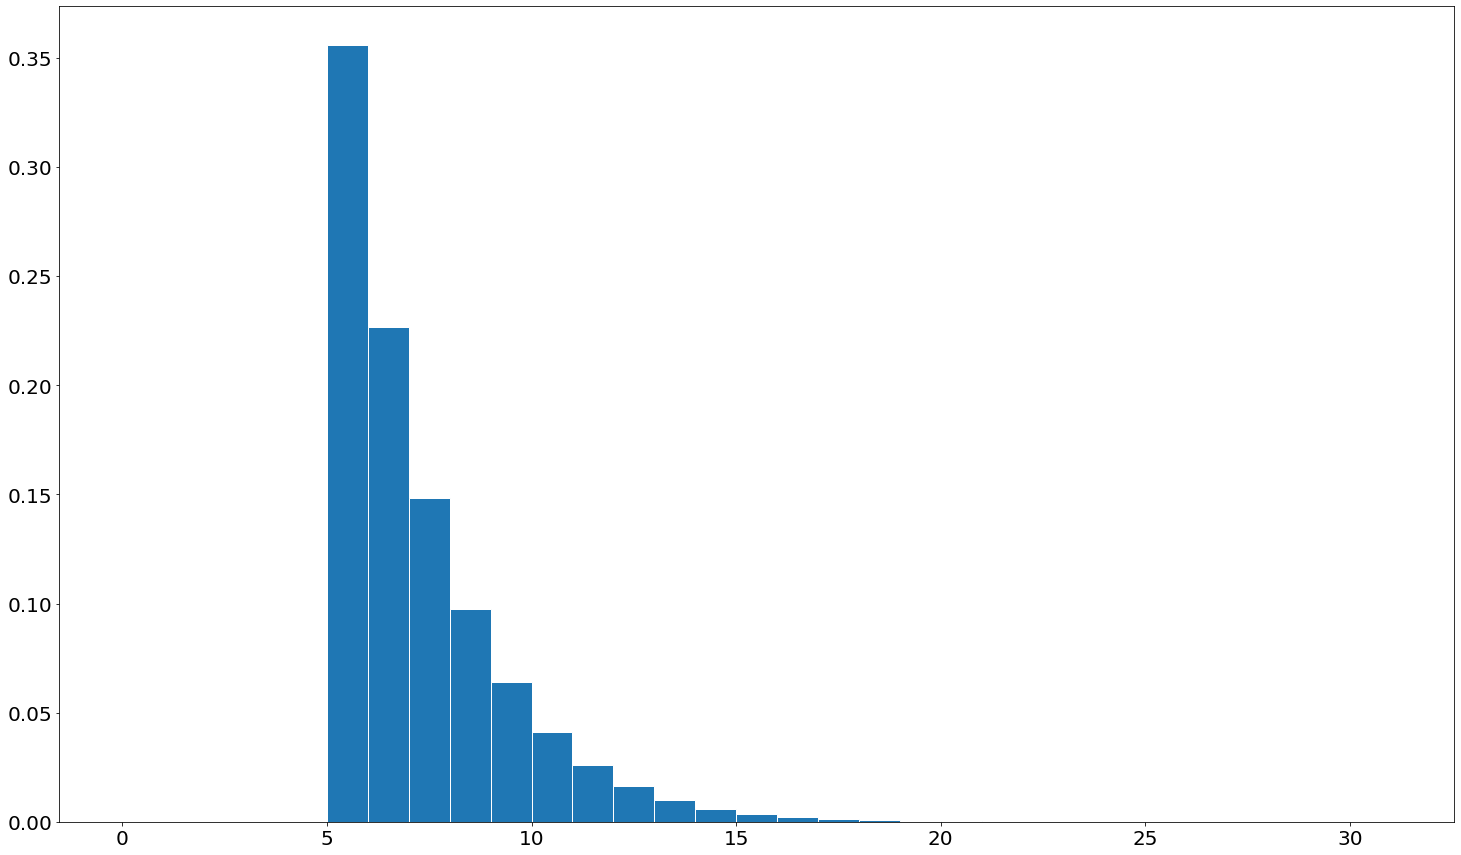

In [53]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_ar39 = undersample_argon(cutar39, round(len(train_ar41))*1.5, augment_from_pe=15, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print(time.time() - init)

In [54]:
print("[Info] Training set")
print("\tAr41: {} instances".format(len(train_ar41)))
print("\tAr39: {} instances".format(len(train_ar39)))

[Info] Training set
	Ar41: 6483 instances
	Ar39: 9785 instances


# features

In [34]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   

In [55]:
# Compute features muon
import time

init = time.time()
df_ar41_feat = pd.DataFrame()
df_ar41_feat["PEDetected_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialStd_inner"] = train_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialStd_outer"] = train_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_tot"] = df_ar41_feat["PEDetected_inner"] + df_ar41_feat["PEDetected_outer"]
df_ar41_feat["NActiveSlices_tot"] = df_ar41_feat["NActiveSlices_inner"] + df_ar41_feat["NActiveSlices_outer"]
df_ar41_feat["MeanNPEActive_tot"] = df_ar41_feat["PEDetected_tot"] / df_ar41_feat["NActiveSlices_tot"]
df_ar41_feat = df_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
df_ar39_feat = pd.DataFrame()
df_ar39_feat["PEDetected_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialStd_inner"] = train_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar39_feat["NActiveSlices_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar39_feat["MeanNPEActive_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar39_feat["SpatialRange_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar39_feat["SpatialStd_outer"] = train_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar39_feat["PEDetected_tot"] = df_ar39_feat["PEDetected_inner"] + df_ar39_feat["PEDetected_outer"]
df_ar39_feat["NActiveSlices_tot"] = df_ar39_feat["NActiveSlices_inner"] + df_ar39_feat["NActiveSlices_outer"]
df_ar39_feat["MeanNPEActive_tot"] = df_ar39_feat["PEDetected_tot"] / df_ar39_feat["NActiveSlices_tot"]
df_ar39_feat = df_ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.571 sec
Compute Mu Outer features: 0.703 sec
Compute combined features: 0.003 sec
Compute Ar39 Inner features: 0.991 sec
Compute Ar39 Outer features: 1.021 sec
Compute combined features: 0.003 sec


# train DTree

In [42]:
# ml imports
import time
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [56]:
# prepare data for training
df_ar39_feat["y"] = 0
df_ar41_feat["y"] = 1
# data preparation
data = pd.concat([df_ar39_feat, df_ar41_feat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

In [57]:
# first: tune base estimator
dt_param_grid = {"criterion" : ["gini", "entropy"],
                 "splitter" :   ["best", "random"],
                 "min_samples_leaf": [int(x) for x in np.linspace(100, 1000, 50)],
                 "min_samples_split": range(2, 50),
                 "max_depth": range(2, 11),
                 "max_features": ["auto", "log2", "sqrt"]
                }

dt = DecisionTreeClassifier()

# run grid search
random_grid_dt = RandomizedSearchCV(dt, param_distributions=dt_param_grid, n_iter=500, cv=5, n_jobs=-1, scoring="roc_auc")
random_grid_dt.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_dt.best_params_)
print(random_grid_dt.best_score_)

[Info] Randomized Search + Cross-Validation
{'splitter': 'best', 'min_samples_split': 48, 'min_samples_leaf': 100, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}
0.9660742733332552


In [59]:
# first: tune base estimator
dt_param_grid = {"min_samples_leaf": [int(x) for x in np.linspace(100, 1000, 100)],
                 "min_samples_split": range(40, 100),
                 "max_depth": range(3, 8),
                 "max_features": ["auto", "log2", "sqrt"]
                }

dt = DecisionTreeClassifier(criterion="entropy", splitter="best")

# run grid search
random_grid_dt = RandomizedSearchCV(dt, param_distributions=dt_param_grid, n_iter=500, cv=5, n_jobs=-1, scoring="roc_auc")
random_grid_dt.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_dt.best_params_)
print(random_grid_dt.best_score_)

[Info] Randomized Search + Cross-Validation
{'min_samples_split': 63, 'min_samples_leaf': 136, 'max_features': 'log2', 'max_depth': 7}
0.9649602555160106


In [61]:
# first: tune base estimator
dt_param_grid = {"min_samples_leaf": [int(x) for x in np.linspace(100, 200, 101)],
                 "min_samples_split": range(40, 71, 5),
                 "max_depth": range(3, 8),
                 "max_features": ["auto", "log2", "sqrt"]
                }

dt = DecisionTreeClassifier(criterion="entropy", splitter="best")

# run grid search
random_grid_dt = GridSearchCV(dt, param_grid=dt_param_grid, cv=5, n_jobs=-1, scoring="roc_auc", verbose=2)
random_grid_dt.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(random_grid_dt.best_params_)
print(random_grid_dt.best_score_)

Fitting 5 folds for each of 10605 candidates, totalling 53025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 5320 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 15688 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 22808 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 31240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 40952 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 51976 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 53025 out of 53025 | elapsed:  2.7min finished


[Info] Randomized Search + Cross-Validation
{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 121, 'min_samples_split': 50}
0.9674701557125843


In [62]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best",
                            max_depth=7, max_features="log2", 
                            min_samples_leaf=121, min_samples_split=50)
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       min_samples_leaf=121, min_samples_split=50)

# tune random forest

In [67]:
# Create the random grid
rf_random_grid = {'n_estimators': range(10, 101),
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': range(5, 11),
                  'min_samples_split': range(2, 51, 2),
                  'min_samples_leaf':  range(100, 1000, 100),
                  'bootstrap': [True, False]
                 }
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_random_grid, scoring="roc_auc", n_iter=100, 
                               cv=5, n_jobs=-1, verbose=2)
rf_random.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.9s finished


[Info] Randomized Search + Cross-Validation
{'n_estimators': 42, 'min_samples_split': 14, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
0.9713766135490921


In [69]:
# Create the random grid
rf_random_grid = {'n_estimators': range(30, 51),
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': range(5, 10),
                  'min_samples_split': range(10, 51),
                  'min_samples_leaf':  range(100, 201),
                  'bootstrap': [True, False]
                 }
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_random_grid, scoring="roc_auc", n_iter=100,
                               cv=5, n_jobs=-1, verbose=2)
rf_random.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.9s finished


[Info] Randomized Search + Cross-Validation
{'n_estimators': 48, 'min_samples_split': 13, 'min_samples_leaf': 110, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': False}
0.9711479469555687


In [72]:
# Create the random grid
rf_random_grid = {'n_estimators': range(40, 51, 2),
                  'max_depth': range(5, 9),
                  'min_samples_split': range(10, 31, 5),
                  'min_samples_leaf':  range(100, 151, 5),
                 }
rf = RandomForestClassifier(max_features="auto", bootstrap=False)
rf_random = GridSearchCV(estimator=rf, param_grid=rf_random_grid, scoring="roc_auc",
                         cv=5, n_jobs=-1, verbose=2)
rf_random.fit(X, y)

print("[Info] Randomized Search + Cross-Validation")
print(rf_random.best_params_)
print(rf_random.best_score_)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 6600 out of 6600 | elapsed: 11.2min finished


[Info] Randomized Search + Cross-Validation
{'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 30, 'n_estimators': 46}
0.9714523491345177


In [73]:
rf = RandomForestClassifier(max_features="auto", bootstrap=False,
                            n_estimators=46, max_depth=8, min_samples_leaf=100, min_samples_split=30)
rf.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=100,
                       min_samples_split=30, n_estimators=46)

# test models

In [75]:
# Compute features muon
import time

init = time.time()
df_test_ar41_feat = pd.DataFrame()
df_test_ar41_feat["PEDetected_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialStd_inner"] = test_ar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar41 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_ar41_feat["NActiveSlices_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_ar41_feat["MeanNPEActive_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_ar41_feat["SpatialRange_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_ar41_feat["SpatialStd_outer"] = test_ar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar41 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_ar41_feat["PEDetected_tot"] = df_test_ar41_feat["PEDetected_inner"] + df_test_ar41_feat["PEDetected_outer"]
df_test_ar41_feat["NActiveSlices_tot"] = df_test_ar41_feat["NActiveSlices_inner"] + df_test_ar41_feat["NActiveSlices_outer"]
df_test_ar41_feat["MeanNPEActive_tot"] = df_test_ar41_feat["PEDetected_tot"] / df_test_ar41_feat["NActiveSlices_tot"]
df_test_ar41_feat = df_test_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar41 Inner features: 0.071 sec
Compute Ar41 Outer features: 0.083 sec
Compute combined features: 0.003 sec


In [77]:
import time

init = time.time()
df_test_1ar39_feat = pd.DataFrame()
df_test_1ar39_feat["PEDetected_inner"] = cutar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_inner"] = cutar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_inner"] = cutar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_inner"] = cutar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialStd_inner"] = cutar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_outer"] = cutar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_test_1ar39_feat["NActiveSlices_outer"] = cutar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_test_1ar39_feat["MeanNPEActive_outer"] = cutar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_test_1ar39_feat["SpatialRange_outer"] = cutar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_test_1ar39_feat["SpatialStd_outer"] = cutar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_test_1ar39_feat["PEDetected_tot"] = df_test_1ar39_feat["PEDetected_inner"] + df_test_1ar39_feat["PEDetected_outer"]
df_test_1ar39_feat["NActiveSlices_tot"] = df_test_1ar39_feat["NActiveSlices_inner"] + df_test_1ar39_feat["NActiveSlices_outer"]
df_test_1ar39_feat["MeanNPEActive_tot"] = df_test_1ar39_feat["PEDetected_tot"] / df_test_1ar39_feat["NActiveSlices_tot"]
df_test_1ar39_feat = df_test_1ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Ar39 Inner features: 47.497 sec
Compute Ar39 Outer features: 51.106 sec
Compute combined features: 0.015 sec


In [80]:
# create label
df_test_1ar39_feat["y"] = 0
df_test_ar41_feat["y"] = 1

# data preparation
all_test_data = pd.concat([df_test_1ar39_feat, df_test_ar41_feat], axis=0)
XX, yy = all_test_data.iloc[:, :-1], all_test_data.iloc[:, -1]
XX = np.array(XX)

In [81]:
# inference
init = time.time()
y_pred_proba_dt = dt.predict_proba(XX)
print("[Info] Inference {} instances wt DTree: {:.3f} seconds".format(XX.shape[0], time.time()-init))

init = time.time()
y_pred_proba_rf = rf.predict_proba(XX)
print("[Info] Inference {} instances wt RandomForest: {:.3f} seconds".format(XX.shape[0], time.time()-init))

all_test_data["y_dt"] = y_pred_proba_dt[:, 1]
all_test_data["y_rf"] = y_pred_proba_rf[:, 1]

[Info] Inference 462641 instances wt DTree: 0.036 seconds
[Info] Inference 462641 instances wt RandomForest: 1.241 seconds


In [82]:
# plot roc curve
dt_fpr, dt_tpr, dt_threshold = roc_curve(yy, all_test_data["y_dt"])
rf_fpr, rf_tpr, rf_threshold = roc_curve(yy, all_test_data["y_rf"])

[Info] DTree: Threshold: 0.45 => TPR: 0.881, FPR=0.106
[Info] DTree: Threshold: 0.71 => TPR: 0.796, FPR=0.038
[Info] DTree: Threshold: 0.87 => TPR: 0.754, FPR=0.024
[Info] RandomForest: Threshold: 0.50 => TPR: 0.883, FPR=0.079
[Info] RandomForest: Threshold: 0.75 => TPR: 0.807, FPR=0.019
[Info] RandomForest: Threshold: 0.85 => TPR: 0.749, FPR=0.008


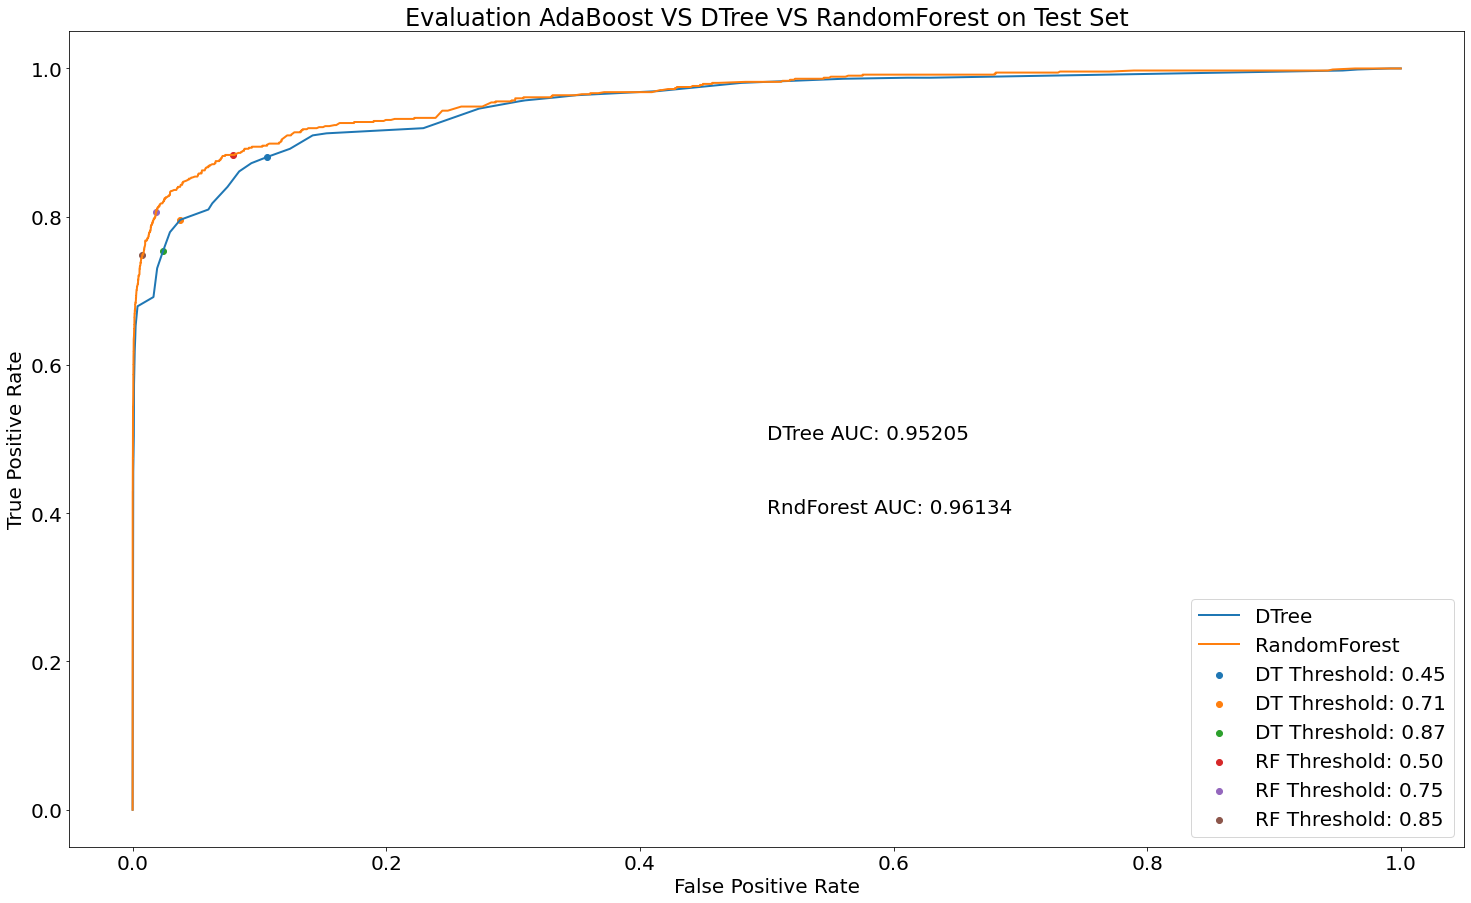

In [100]:
highlight_thresholds = [.50, .75, .85]
plt.plot(dt_fpr, dt_tpr, label="DTree", linewidth=2)
for threshold in highlight_thresholds:
    dt_mid_threshold = np.argmin(abs(dt_threshold-threshold))
    plt.scatter(dt_fpr[dt_mid_threshold], dt_tpr[dt_mid_threshold], label="DT Threshold: {:.2f}".format(dt_threshold[dt_mid_threshold]))
    print("[Info] DTree: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(dt_threshold[dt_mid_threshold], dt_tpr[dt_mid_threshold], dt_fpr[dt_mid_threshold]))

plt.text(.5, .5, "DTree AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_dt"])))

plt.plot(rf_fpr, rf_tpr, label="RandomForest", linewidth=2)
for threshold in highlight_thresholds:
    rf_mid_threshold = np.argmin(abs(rf_threshold-threshold))
    plt.scatter(rf_fpr[rf_mid_threshold], rf_tpr[rf_mid_threshold], label="RF Threshold: {:.2f}".format(rf_threshold[rf_mid_threshold]))
    print("[Info] RandomForest: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(rf_threshold[rf_mid_threshold], rf_tpr[rf_mid_threshold], rf_fpr[rf_mid_threshold]))
plt.text(.5, .40, "RndForest AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_rf"])))


plt.title("Evaluation AdaBoost VS DTree VS RandomForest on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

array([2.        , 1.        , 0.99574468, 0.98947368, 0.98360656,
       0.97424893, 0.96062992, 0.94736842, 0.93121693, 0.91304348,
       0.90322581, 0.86956522, 0.7960199 , 0.71038251, 0.70588235,
       0.703125  , 0.65470852, 0.64317181, 0.57303371, 0.44692737,
       0.44      , 0.42040816, 0.30327869, 0.24456522, 0.23951049,
       0.17827298, 0.17741935, 0.13063063, 0.12121212, 0.11018711,
       0.10240964, 0.0719755 , 0.02840909, 0.02777778, 0.02715194,
       0.02097902, 0.00588235, 0.        ])

In [84]:
from joblib import dump
dump(dt, 'models/dt_1ar39_vs_ar41_11_09_2020.joblib') 
dump(rf, 'models/rf_1ar39_vs_ar41_11_09_2020.joblib') 
print("[Info] Saved models.")

[Info] Saved models.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


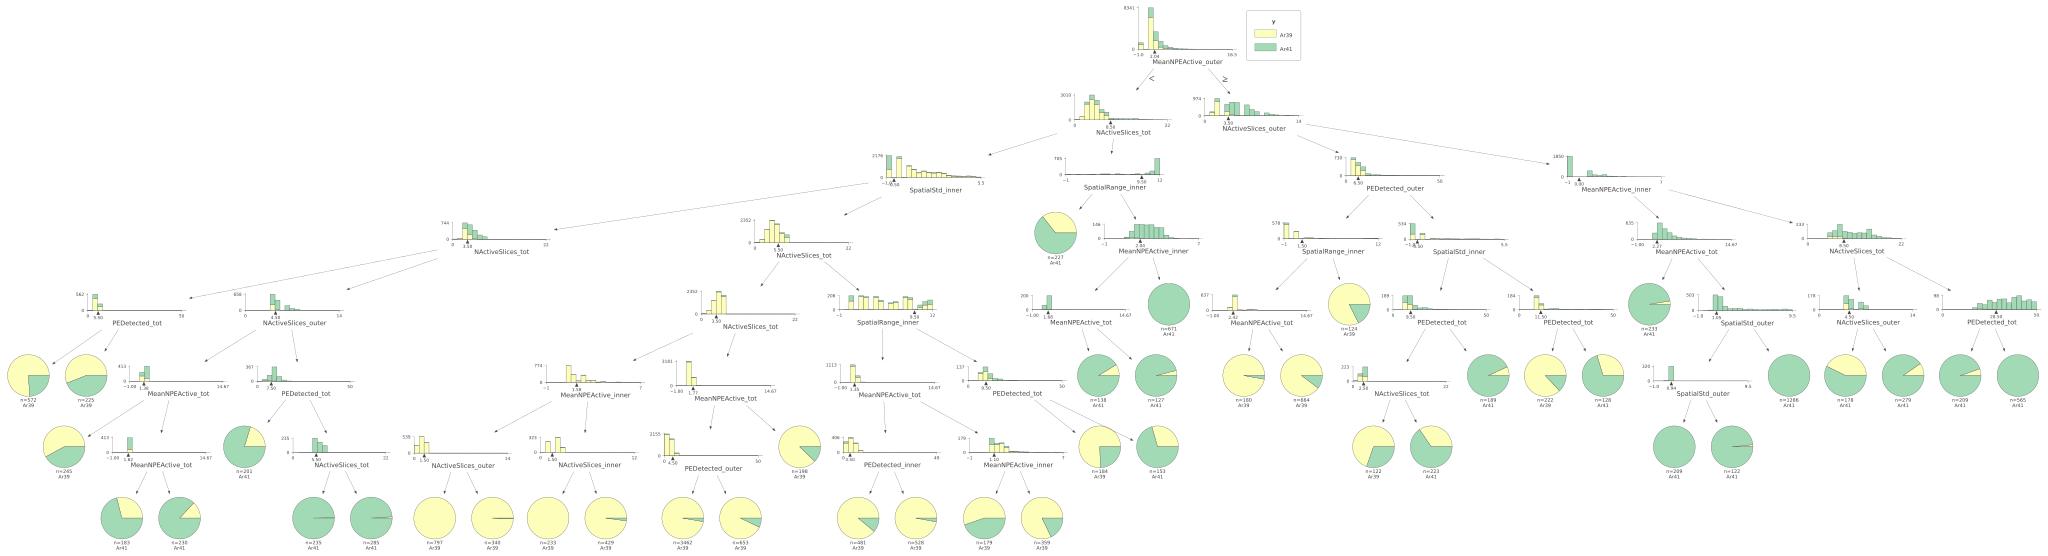

In [88]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(dt, X, y,
               target_name="y",
               feature_names=df_ar39_feat.columns[:-1],
               class_names=["Ar39", "Ar41"])
viz

In [89]:
viz.save("models/dt_1ar39_vs_ar41_11_09_2020.svg")